# Transpiling Quantum Circuits
### Anurag Saxena, Software Developer II
### Center for Immunotherapy & Prescision Immuno-Oncology

This notebook was taken from IBM Quantum Documentation and modified for some simplicity and to add some IBM Cleveland Components. 

Link to Documentation: https://docs.quantum.ibm.com/transpile

# What is Transpilation
- Process of rewriting your circuit to match the circuit topology of a specific quantum device.

# Why Transpile?
- Circuits you build if implemented directly are inefficient.
    - Because each hardware has a unique cirucit topology. 
- To optimize the circuit for execution within the limitations of the hardware you are running on. 
    - Devices are noisy. 
    - We want to reduce noise as much as possible. 
    - This is done by reducing the number of gates (or the circuit depth) as much as possible. 
    - Less gates = Less depth which means less operations which translates to less noise (error). 

# Qiskit Transpiler Module
- Used to transform your circuit
- Goal is to write new circuit transformations (known as transpiler *passes*) and combine them with existing passes. 
    - This helps in reducing circuit depth and complexity of the circuit. 
- Transpilation pipeline is determined by two objects: `PassManager` and `StagedPassManager`

## `Passmanager`
- Collection of passes

## `StagedPassManager`
- Orchestrates the execution of one or more `Passmanagers`

Think of the `StagedPassManager` as the conductor in an orchestra, the `PassManagers` as the different instrument sections, and the `Pass`es as the individual musicians. 
In this way, you can compose hardware-efficient quantum circuits that let you execute utility-scale work while keeping noise manageable.

# Transpiler Stages
For the sake of this presentation, we will focus on the built-in Qiskit Transpilation Routine.

By default the preset pass managers are composed of six stages: 

- `init` - This stage runs any initial passes that are required before we start embedding the
   circuit to the backend. This typically involves unrolling custom instructions and converting the circuit to all 1 and 2 qubit gates.

- `layout` - This stage applies a `layout`, mapping the virtual qubits in the circuit to the
   physical qubits on a backend.

- `routing` - This stage runs after a `layout` has been applied and will inject
   gates (i.e. swaps) into the original circuit to make it compatible
   with the backend's connectivity/coupling map.

- `translation` - This stage translates the gates in the circuit to the target backend's basis set 
   of instructions.

- `optimization` - This stage runs the main `optimization` loop repeatedly
   until a condition (such as fixed depth) is reached.

- `scheduling` - This stage is for any hardware-aware `scheduling` passes. If the user specifies a 
   scheduling method, this stage accounts for all idle time in the circuit.

## Init stage

Unless you are passing any custom instructions, this stage does very little. 

It does convert gates operating on more than two qubits to 1 or 2 qubit gates.


## Layout stage

This depends on the hardware to which your circuit is being sent to. 

To execute a sequence of gates, a one-to-one mapping from the "virtual" qubits to the "physical" qubits in an actual quantum device is necesary.  This mapping is stored as a `Layout` object.

This step is used to minimize the number of swaps needed to map the input circuit on to the device topology to ensure the most well calibrated qubits are used. 

![This image illustrates qubits being mapped from the wire representation to a diagram that represents how the qubits are connected on the system.](layout-mapping@dark.png "Qubit mapping")

# Layout Stage

The Pass manager uses a two step method to find the best layout. 
- Trivial Layout Pass: Naively match each virtual qubit to the same number of physical qubit. 
- VF2 Layout Pass: Uses the VF2++ algorithm and scoring heuristics to select the mapping with the lowest average error. 


# Routing Stage

This stage runs after a `layout` has been applied and will inject gates (i.e. swaps) into the original circuit to make it compatible with the backend's connectivity/coupling map.

# Translation Stage

This stage translates the gates from the user provided circuit to the quantum gate and non gate operations that are natively supported by the target quantum hardware. 

e.g. IBM Cleveland has the following Basis Gates and gate operations: 'id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'for_loop', 'switch_case', 'if_else', 'delay'

This step executes the circuit for translation purposes and leads to an increase in depth and number of gates. 

# Optimization Stage

This stage tries to minimize the depth of the circuit. An `optimization_level` can be passed in the generation
of the preset pass manager. This can be 0, 1, 2, or 3. Higher levels generate more optimized circuits, at the expense of longer transpilation time:
- 0: no optimization
- 1: light optimization
- 2: heavy optimization
- 3: even heavier optimization

Additionally, this stage also executes a few final checks to make sure that all instructions in the circuit are composed of the basis gates available on the target backend.

# Scheduling Stage

This is optional and used account for all the idle time in the circuit. This is done by inserting delays into the circuit to account for the idle time on the qubits between the execution. Valid choices are 
- `alap` (as late as possible): Schedule pulses late– keep qubits in the ground state when possible.
- `asap` (as soon as possible): Schedule pulses greedily, as early as possible on a qubit resource.

Text(0, 0.5, 'Counts')

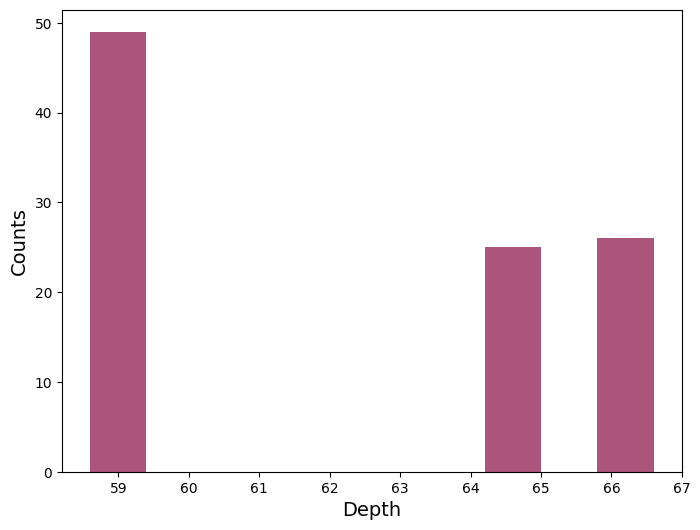

In [77]:
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit_ibm_runtime.fake_provider import FakeAuckland, FakeWashington
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = FakeAuckland()

"""
A GHZ only uses an H on the first qubit and then CNOT (controlled inverse) for the other qubits,
which ties them all together in an entangled state.
Any change to the first qubit will be reflected on the other entangled qubits.
"""

ghz = QuantumCircuit(15)
ghz.h(0)

# cnot flips the target if the control is in 1 state. 1,0 is 1,1, and 1,1 is 1,0.
ghz.cx(0, range(1, 15))

pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=backend,
    layout_method="trivial",  # Fixed layout mapped in circuit order
)
depths = []
for _ in range(100):
    depths.append(pass_manager.run(ghz).depth())

plt.figure(figsize=(8, 6))
plt.hist(depths, align="left", color="#AC557C")
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Counts", fontsize=14)

This wide distribution demonstrates how difficult it is for the SWAP mapper to compute the best mapping.  To gain some insight, let's look at both the circuit being executed as well as the qubits that were chosen on the hardware.


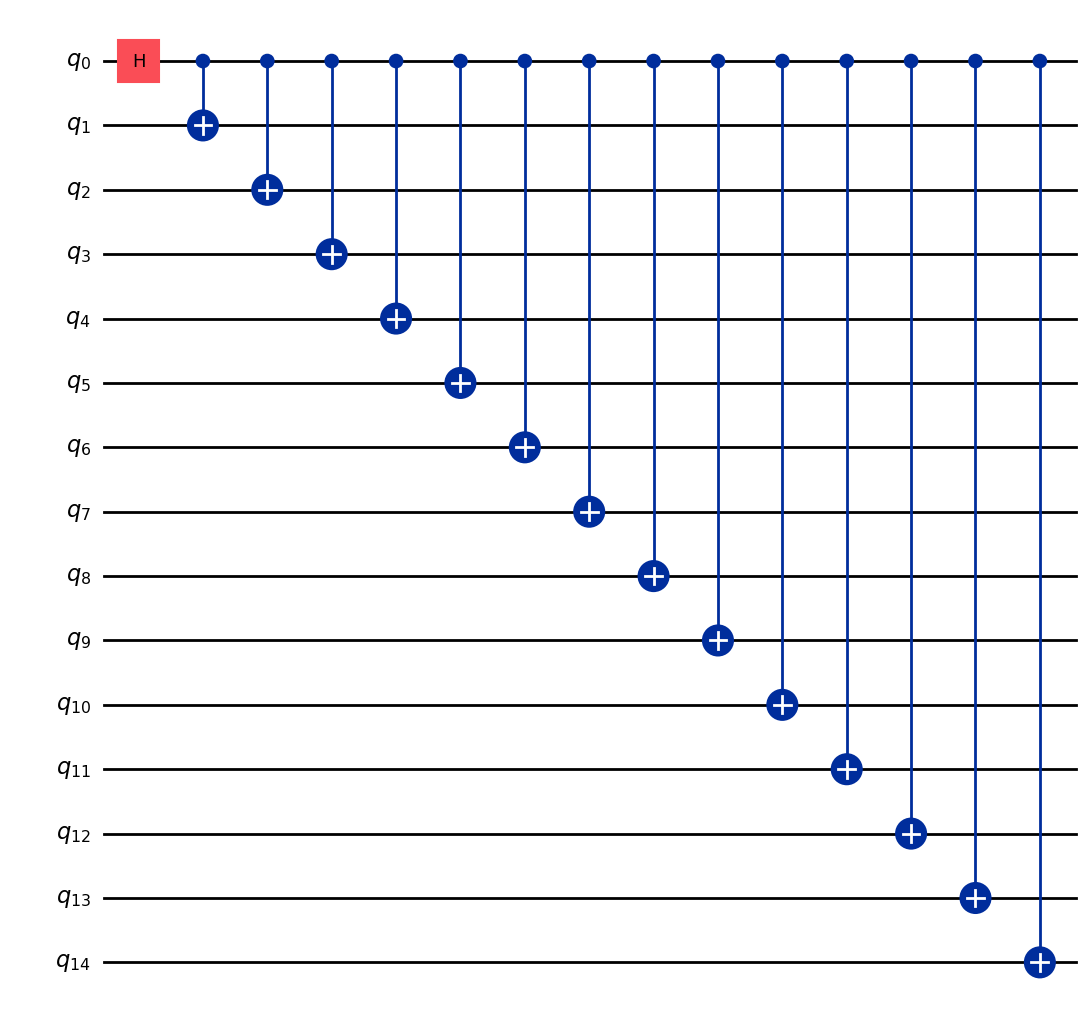

In [78]:
ghz.draw('mpl', idle_wires=False)

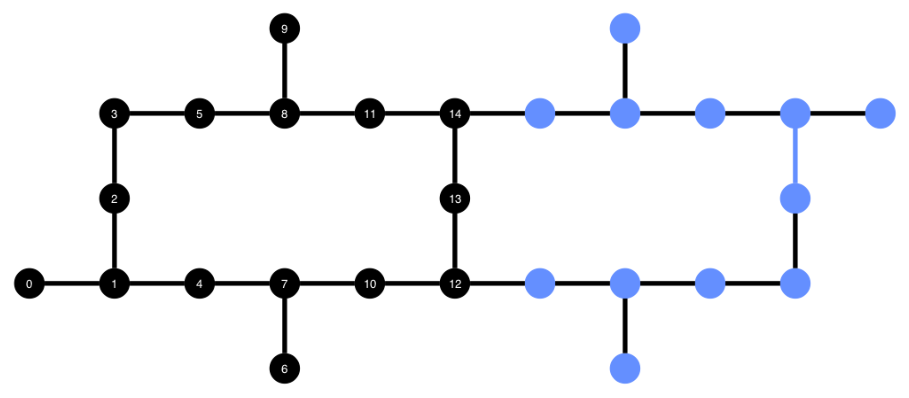

In [79]:
from qiskit.visualization import plot_circuit_layout

# Plot the hardware graph and indicate which hardware qubits were chosen to run the circuit
transpiled_circ = pass_manager.run(ghz)
plot_circuit_layout(transpiled_circ, backend)

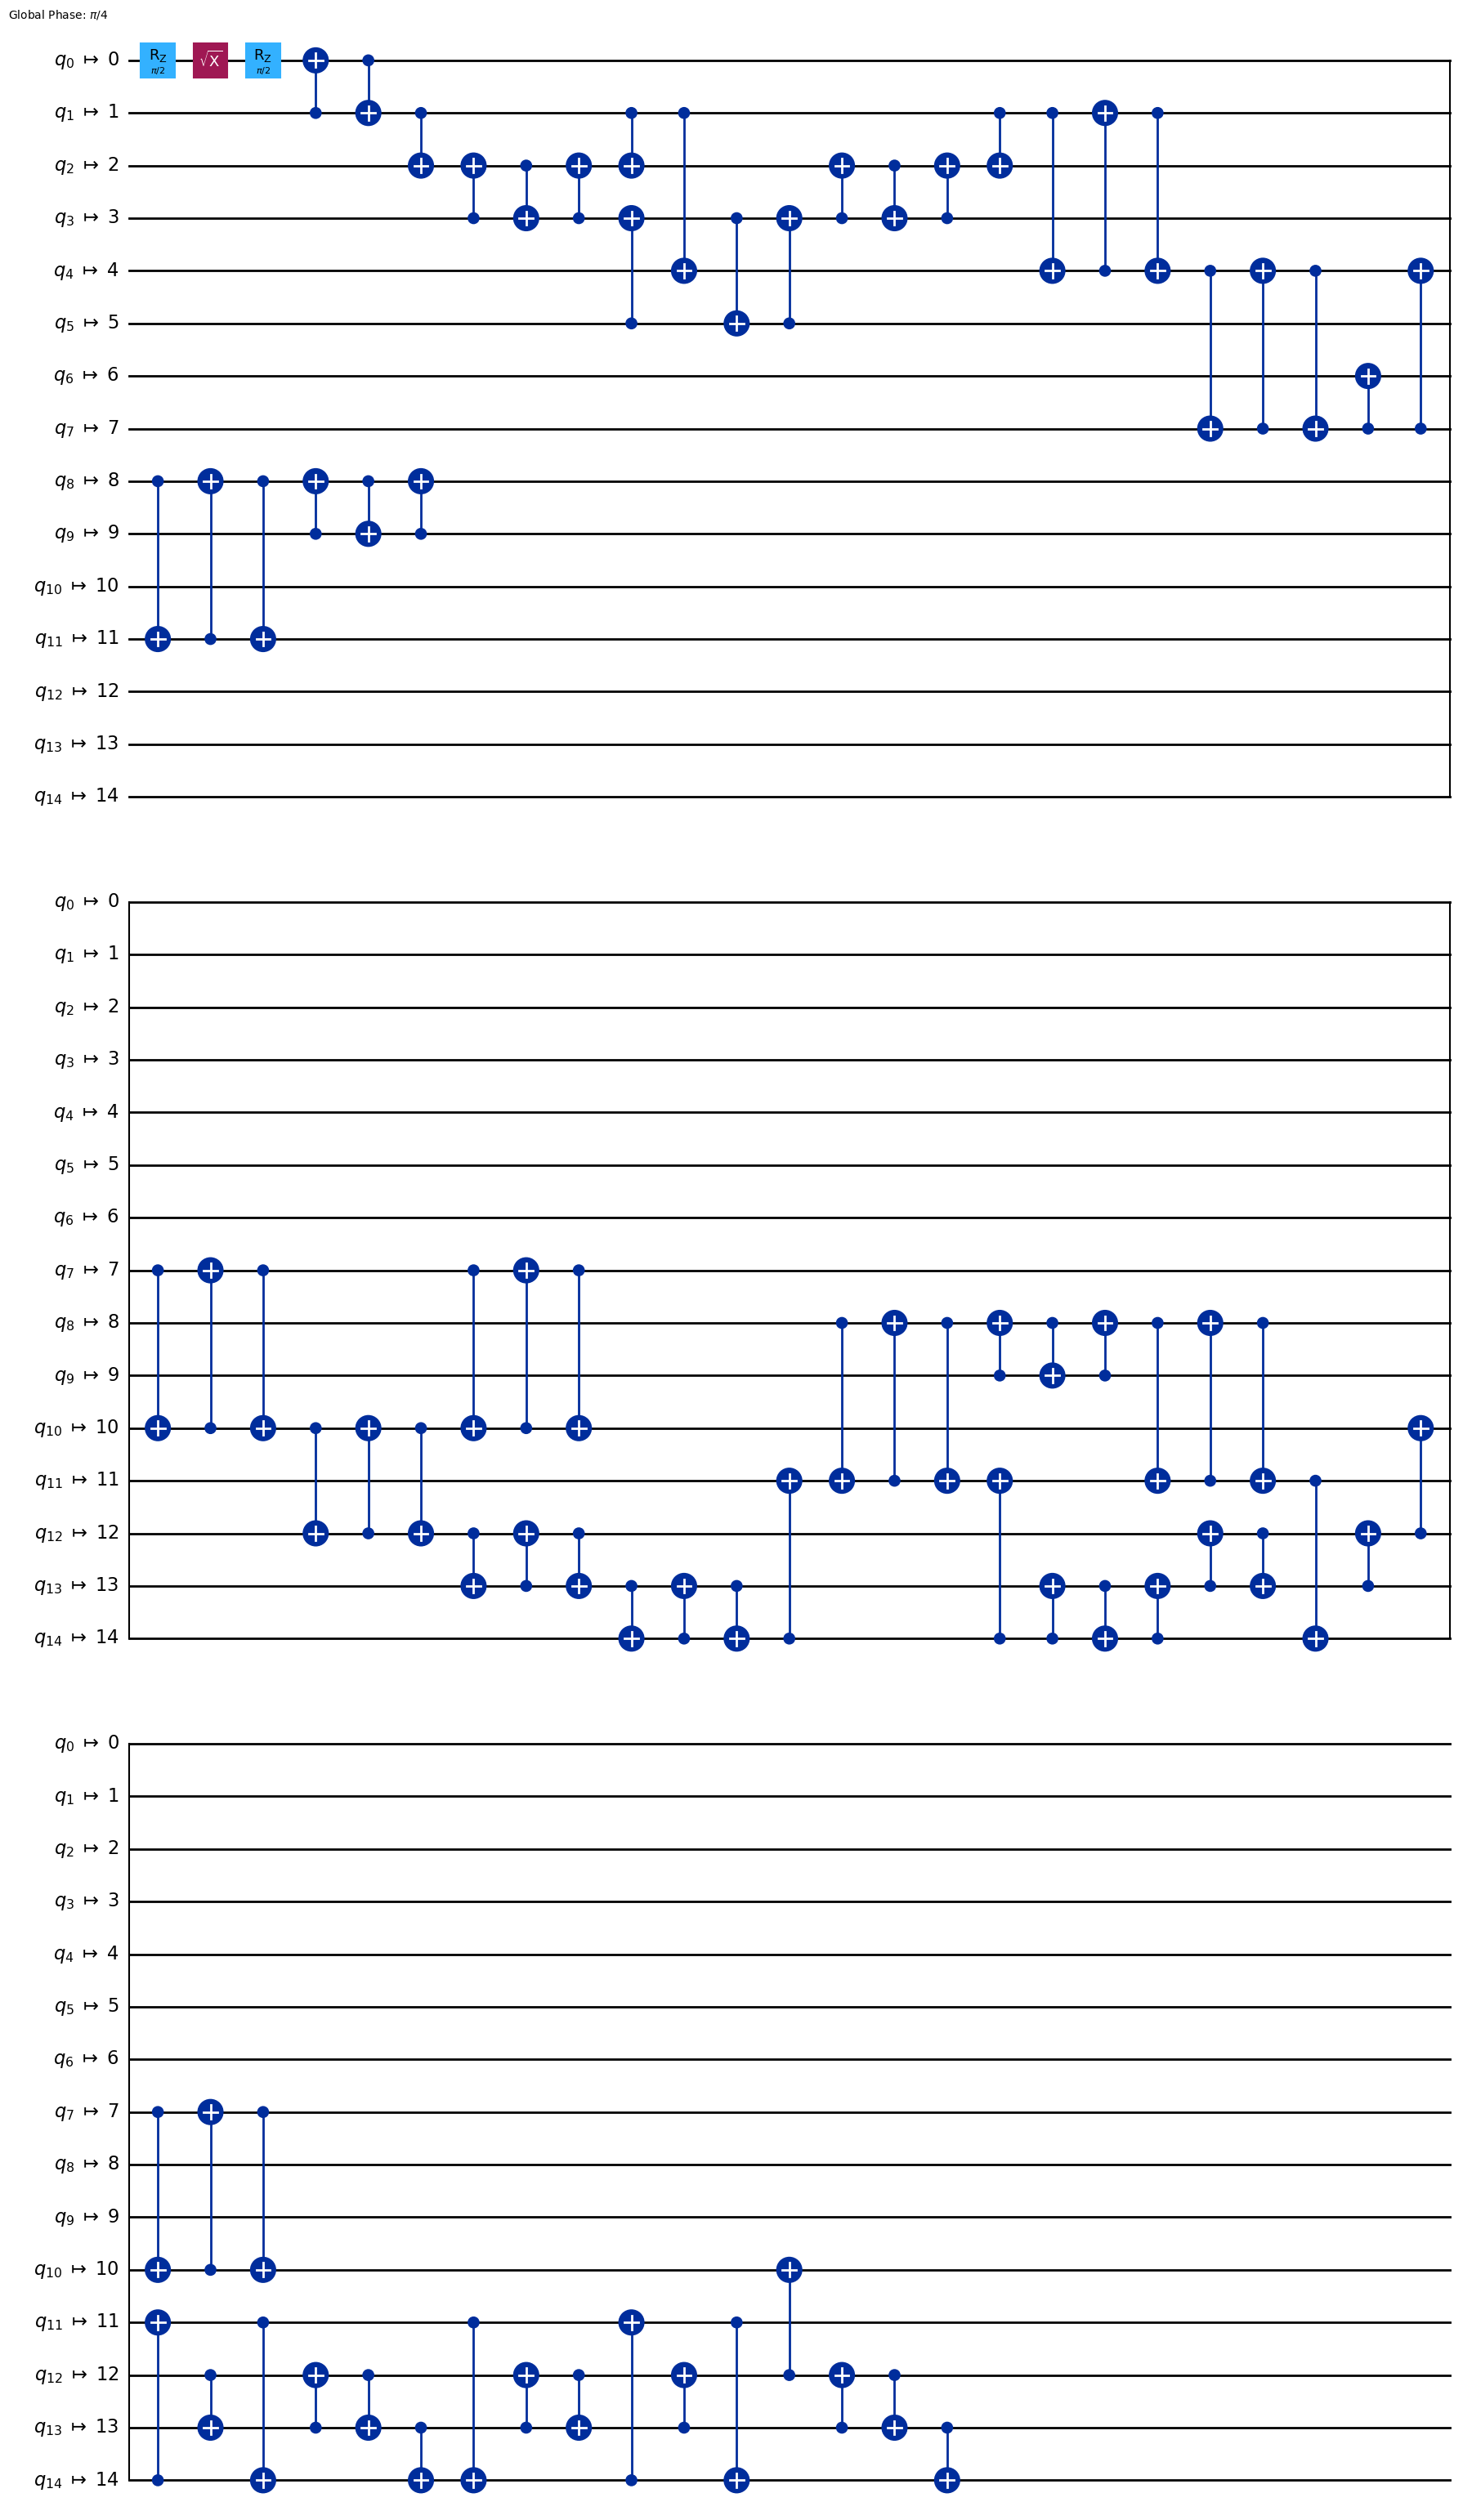

In [80]:
transpiled_circ.draw('mpl', idle_wires=False)
# Output shows several possible transpiled circuits

In [81]:
print("native gates:" + str(backend.operation_names))
# qc = QuantumCircuit(2)
# qc.swap(0, 1)
# qc.decompose().draw('mpl')

native gates:['reset', 'sx', 'x', 'rz', 'delay', 'cx', 'measure', 'id']


In [82]:
from qiskit import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import transpiler
service = QiskitRuntimeService()

print(qiskit.__version__)
print(service.backends())


1.0.2
[<IBMBackend('ibm_cleveland')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>, <IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>]


In [83]:
cle_backend = service.backend("ibm_cleveland")
print(
    f"Name: {cle_backend.name}\n"
    f"Online Date: {cle_backend.online_date}\n"
    f"Version: {cle_backend.version}\n"
    f"Backend Version: {cle_backend.backend_version}\n"
    f"No. of qubits: {cle_backend.num_qubits}\n"
    f"Native Gates: {cle_backend.operation_names}\n"
)

Name: ibm_cleveland
Online Date: 2022-12-03 05:00:00+00:00
Version: 2
Backend Version: 1.4.1
No. of qubits: 127
Native Gates: ['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'for_loop', 'switch_case', 'if_else', 'delay']



Text(0, 0.5, 'Counts')

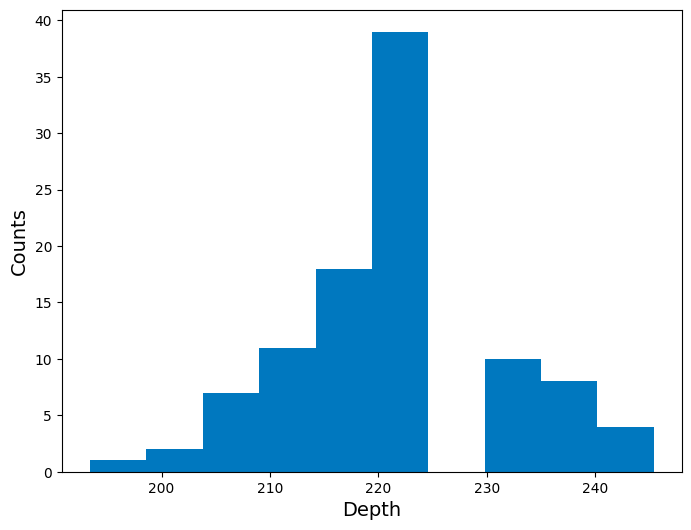

In [84]:
cle_pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    backend=cle_backend,
    layout_method="trivial",  # Fixed layout mapped in circuit order
)
cle_depths = []
for _ in range(100):
    cle_depths.append(cle_pass_manager.run(ghz).depth())

plt.figure(figsize=(8, 6))
plt.hist(cle_depths, align="left", color="#0078bf")
plt.xlabel("Depth", fontsize=14)
plt.ylabel("Counts", fontsize=14)

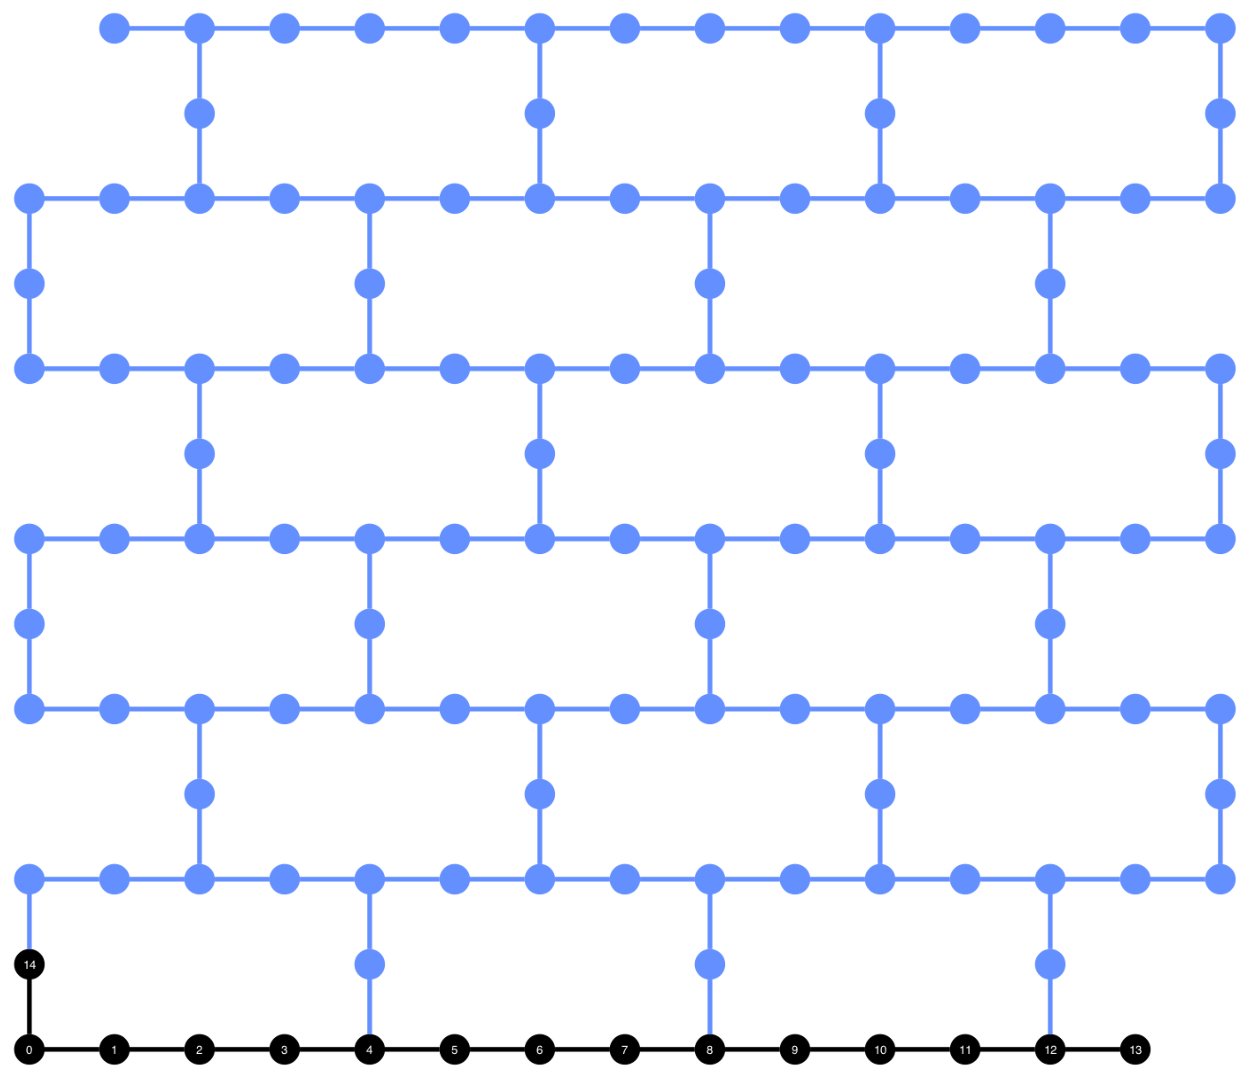

In [85]:
from qiskit.visualization import plot_circuit_layout

# Plot the hardware graph and indicate which hardware qubits were chosen to run the circuit
cle_transpiled_circ = cle_pass_manager.run(ghz)
plot_circuit_layout(cle_transpiled_circ, cle_backend)

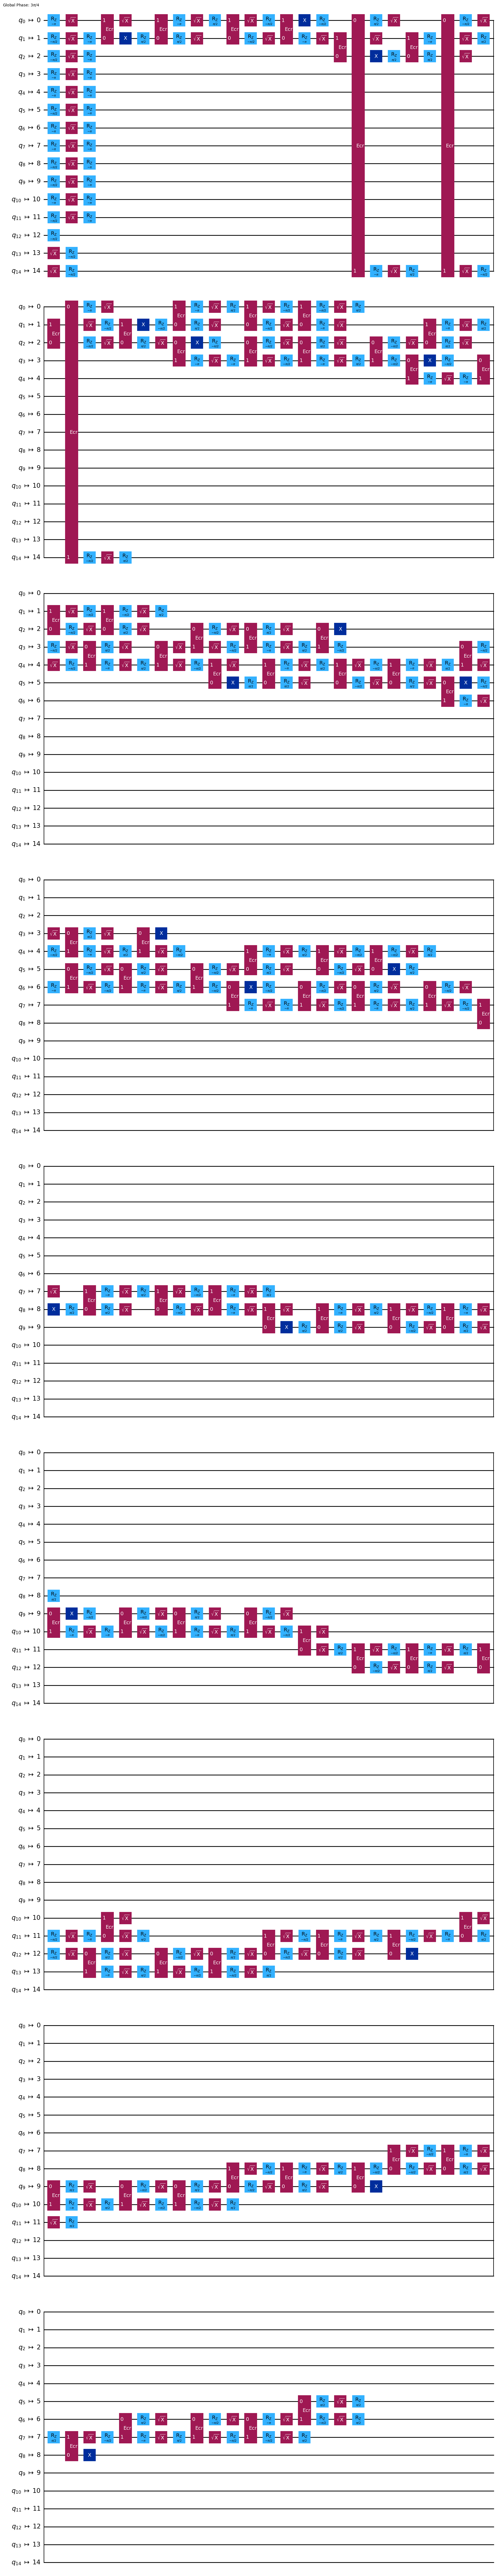

In [86]:
cle_transpiled_circ.draw('mpl', idle_wires=False)

In [87]:
cle_backend.operation_names

['id',
 'rz',
 'sx',
 'x',
 'ecr',
 'reset',
 'measure',
 'for_loop',
 'switch_case',
 'if_else',
 'delay']

/Users/saxenaa/dev/qubite/transpiling-demo/venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/saxenaa/dev/qubite/transpiling-demo/venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/saxenaa/dev/qubite/transpiling-demo/venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/saxenaa/dev/qubite/transpiling-demo/venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/saxenaa/dev/qubite/transpiling-demo/venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, sig

depths=[536, 168, 139, 181]
gate_counts=[1447, 338, 279, 351]
multiqubit_gate_counts=[116, 56, 47, 44]


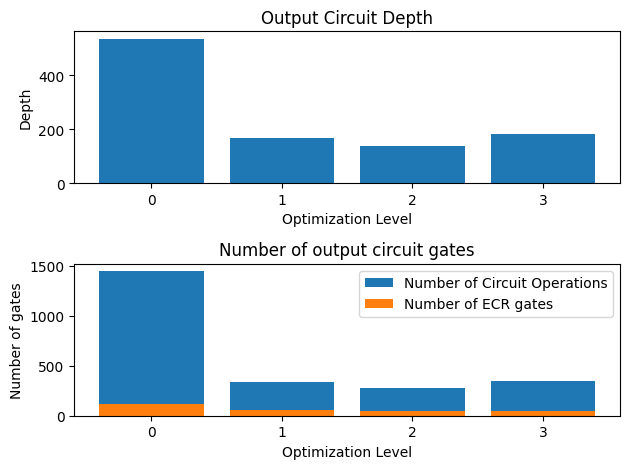

In [95]:
ghz = QuantumCircuit(15)
ghz.h(0)
ghz.cx(0, range(1, 15))

depths = []
gate_counts = []
multiqubit_gate_counts = []
levels = [str(x) for x in range(4)]
for level in range(4):
    pass_manager = generate_preset_pass_manager(
        optimization_level=level,
        backend=cle_backend,
    )
    circ = pass_manager.run(ghz)
    # print(f"{circ.depth()=}")
    depths.append(circ.depth())
    # print(f"{circ.count_ops().values()=}")
    gate_counts.append(sum(circ.count_ops().values()))
    # print(circ.count_ops())
    multiqubit_gate_counts.append(circ.count_ops()["ecr"])

print(f"{depths=}")
print(f"{gate_counts=}")
print(f"{multiqubit_gate_counts=}")

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.bar(levels, depths, label="Depth")
ax1.set_xlabel("Optimization Level")
ax1.set_ylabel("Depth")
ax1.set_title("Output Circuit Depth")
ax2.bar(levels, gate_counts, label="Number of Circuit Operations")
ax2.bar(levels, multiqubit_gate_counts, label="Number of ECR gates")
ax2.set_xlabel("Optimization Level")
ax2.set_ylabel("Number of gates")
ax2.legend()
ax2.set_title("Number of output circuit gates")
fig.tight_layout()
plt.show()

## Scheduling

This last stage is only run if it is explicitly called for (similar to the Init stage) and does not run by default (though a method can be specified by setting the `scheduling_method` argument when calling `generate_preset_pass_manager`).  The scheduling stage is typically used once the circuit has been translated to the target basis, mapped to the device, and optimized.  These passes focus on accounting for all the idle time in a circuit.  At a high level, the scheduling pass can be thought of as explicitly inserting delay instructions to account for the idle time between gate executions and to inspect how long the circuit will be running on the backend.

Here is an example:

In [89]:
cle_backend_timing = cle_backend.configuration().timing_constraints

print(cle_backend_timing)

{'acquire_alignment': 16, 'granularity': 16, 'min_length': 64, 'pulse_alignment': 16}


Acquire Alignment - An integer value representing a time resolution of measure instruction starting time

Granularity - level of detail or precision with which we can measure or control aspects of the quantum system

Min Length - minimum duration of the control pulse used to implement a quantum gate on a quantum hardware. The control pulses implement the quantum gates on hardware. 

Pulse Alignment - Pulse Alignment refers to the precise scheduling and arrangement of pulse signals that are sent to the qubits. These pulses are used to manipulate the quantum states of the qubits, and their alignment is crucial for the correct execution of quantum operations

Scheduling comes in very handy when you are using the control pulses directly for creating custom gates. 

Details on the Qiskit Pulse Module is here: https://docs.quantum.ibm.com/api/qiskit/pulse

Details on pulse scheduling is here: 
https://docs.quantum.ibm.com/build/pulse

/Users/saxenaa/dev/qubite/transpiling-demo/venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/saxenaa/dev/qubite/transpiling-demo/venv/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


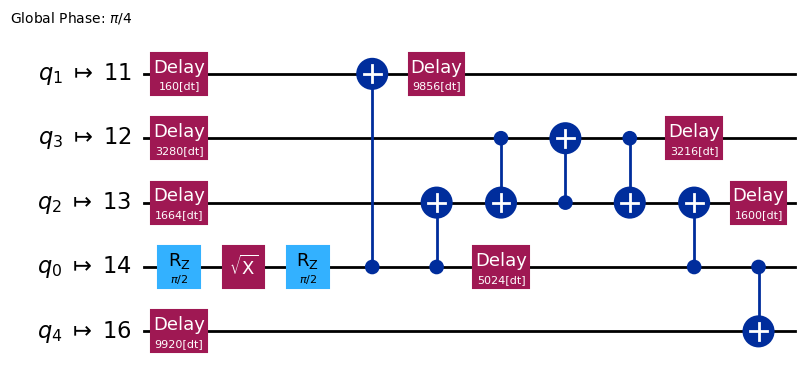

In [90]:
from qiskit.transpiler.timing_constraints import TimingConstraints

ghz = QuantumCircuit(5)
ghz.h(0)
ghz.cx(0, range(1, 5))


timing_constraints = TimingConstraints(
    granularity=cle_backend_timing['granularity'],
    min_length=cle_backend_timing['min_length'],
    pulse_alignment=cle_backend_timing['pulse_alignment'],
    acquire_alignment=cle_backend_timing['acquire_alignment'])


# Run with optimization level 3 and 'asap' scheduling pass
pass_manager = generate_preset_pass_manager(
    optimization_level=3,
    backend=backend,
    timing_constraints=timing_constraints,
    scheduling_method="asap"
)


circ = pass_manager.run(ghz, backend)
circ.draw(output="mpl", idle_wires=False)

The transpiler inserted `Delay` instructions to account for idle time on each qubit. To get a better idea of the timing of the circuit we can also look at it with the timeline.draw() function:

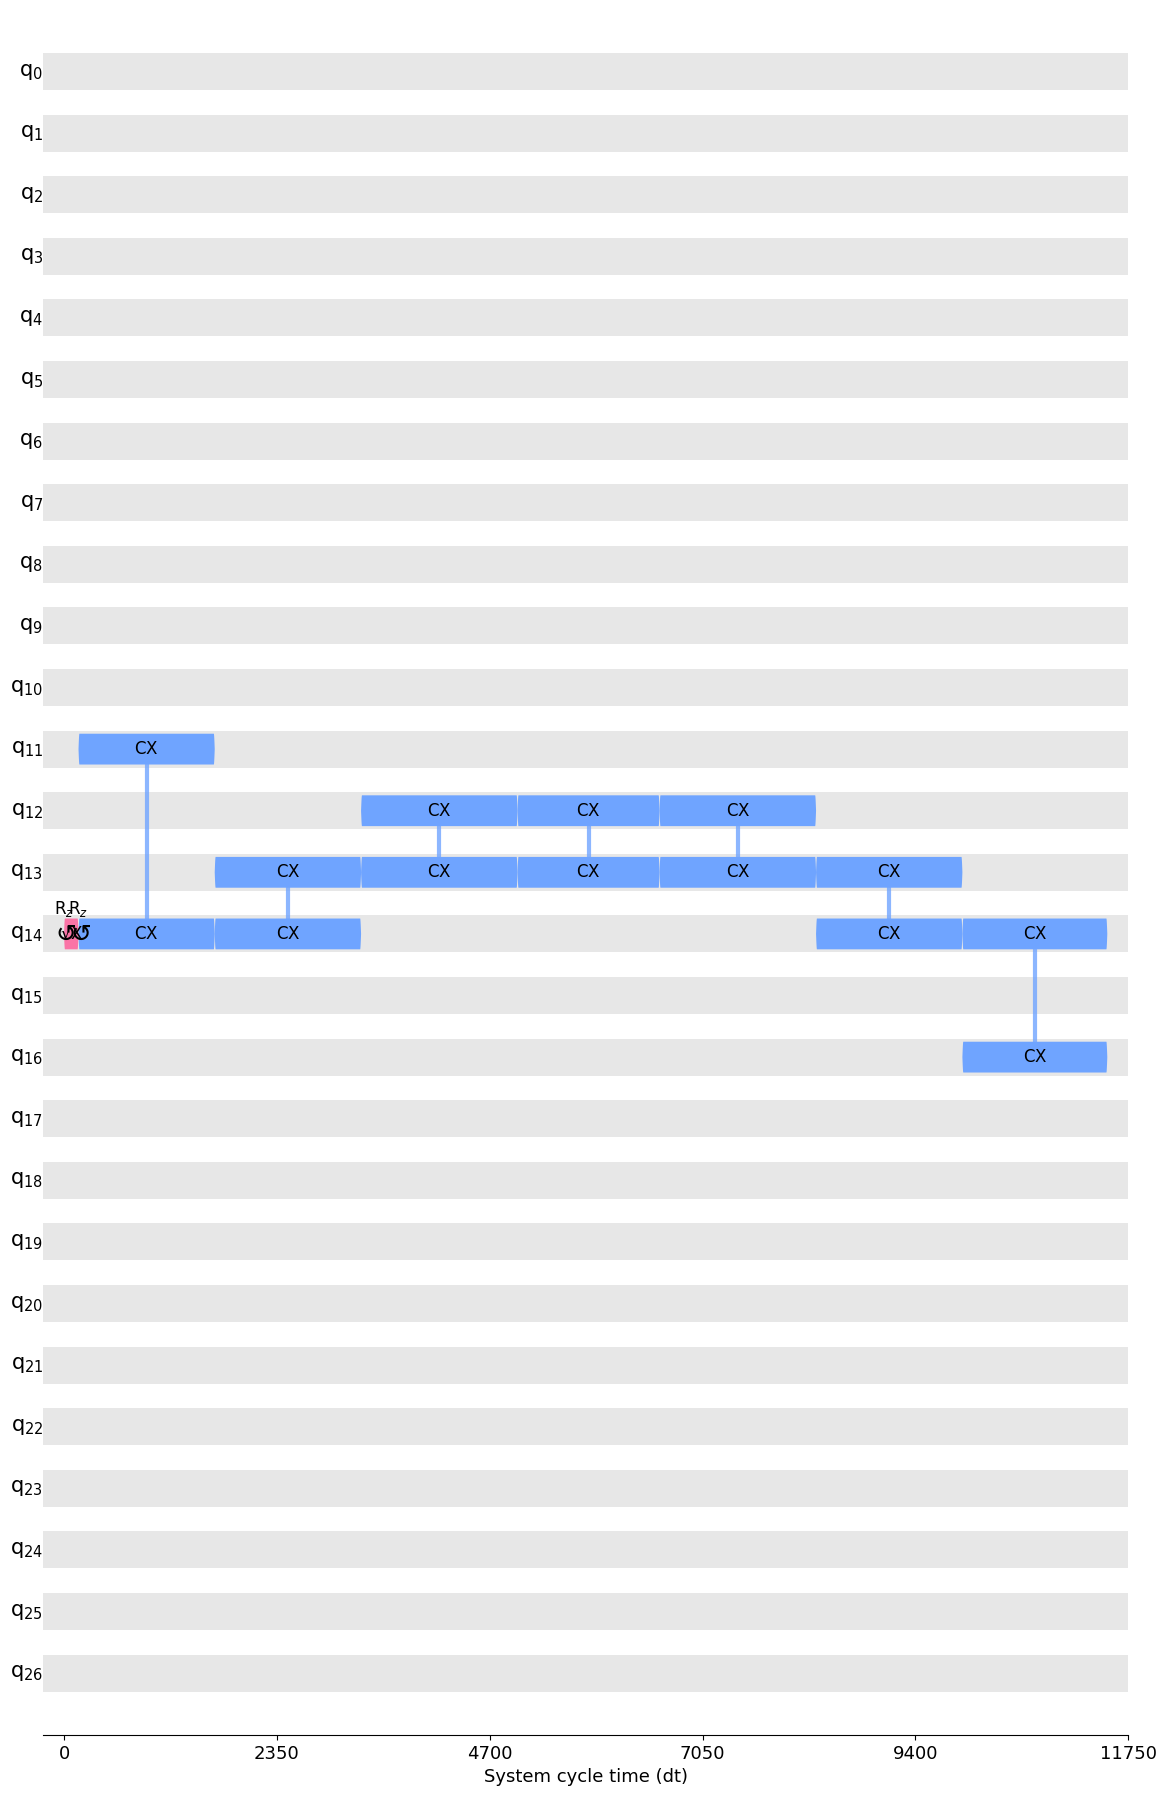

In [91]:
from qiskit.visualization import timeline_drawer

timeline_drawer(circ)